<a href="https://colab.research.google.com/github/FaizaBenzir/gradeVisionAI/blob/main/445.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.cluster import hierarchy
import joblib
from tabulate import tabulate

In [47]:
# Load your dataset
df = pd.read_csv("dataset.csv").dropna(axis = 1)

In [48]:
#Display the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               501 non-null    object
 1   University           501 non-null    object
 2   Year                 501 non-null    object
 3   Interest             501 non-null    int64 
 4   Support              501 non-null    int64 
 5   Visit Resource       501 non-null    int64 
 6   Announcement Check   501 non-null    int64 
 7   Class Participation  501 non-null    int64 
 8   Attendence           501 non-null    object
 9   Study Hours          501 non-null    object
 10  Group Study          501 non-null    int64 
 11  CGPA                 501 non-null    object
 12  Stress Level         501 non-null    int64 
 13  class                501 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 54.9+ KB


In [49]:
# Remove the 'CGPA' column
df = df.drop("CGPA", axis=1)

In [50]:
# Display the first few rows of the dataset
df.head()

,Gender,University,Year,Interest,Support,Visit Resource,Announcement Check,Class Participation,Attendence,Study Hours,Group Study,Stress Level,class
0,Female,NSU,3rd,2,5,2,4,1,75-100,2,3,3,0
1,Male,NSU,4th,3,4,4,5,4,75-100,2,3,3,0
2,Male,NSU,4th,5,5,4,4,4,75-100,2,5,0,1
3,Female,IUBAT,4th,4,4,5,5,1,75-100,2,4,4,1
4,Male,NSU,3rd,4,5,5,2,4,75-100,2,4,3,1


In [51]:
# Identify missing values
missing_values = df.isnull().sum()

# Display the missing values for each column
print("Missing Values:")
print(missing_values)

Missing Values:
Gender                 0
University             0
Year                   0
Interest               0
Support                0
Visit Resource         0
Announcement Check     0
Class Participation    0
Attendence             0
Study Hours            0
Group Study            0
Stress Level           0
class                  0
dtype: int64


In [52]:
# Check unique values in the 'class' column
df["class"].unique()

array([0, 1])

In [53]:
sum(df["class"] == 0)

157

In [54]:
sum(df["class"] == 1)

344

<ipython-input-55-19b2be542454>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




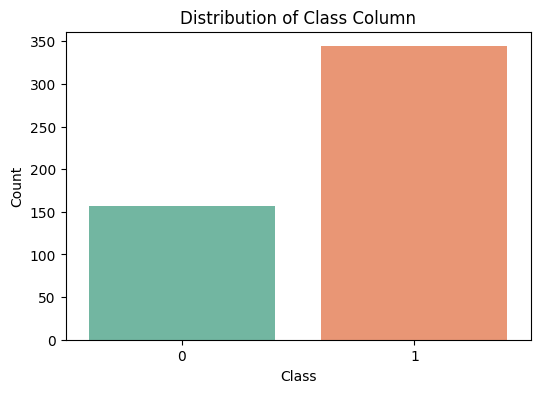

In [55]:
# Display the distribution of the 'class' column
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, palette='Set2')
plt.title('Distribution of Class Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [56]:
# Visualize the distribution of features for each class
cols = df.columns.tolist()
cols.remove("class")

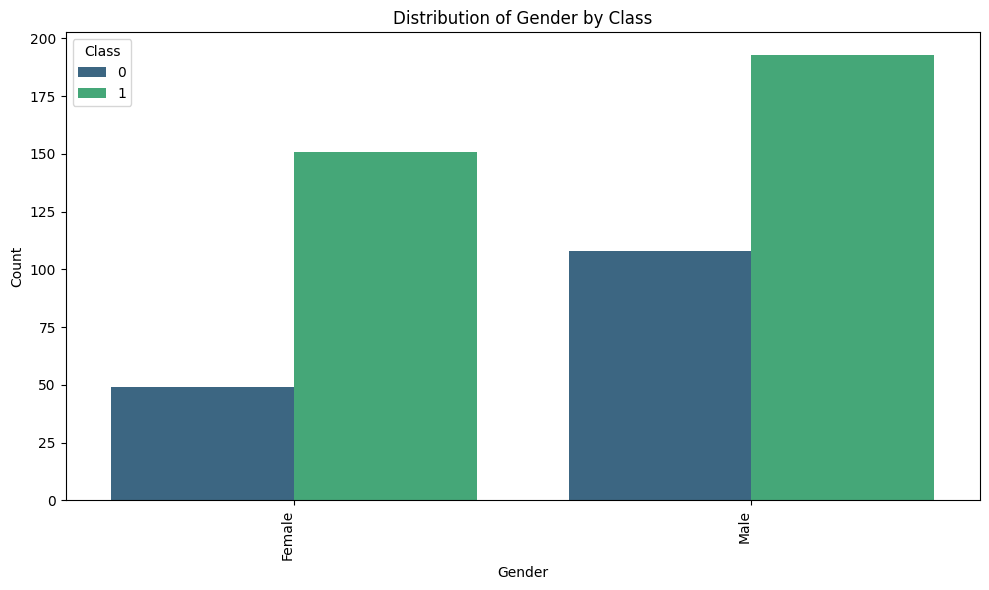

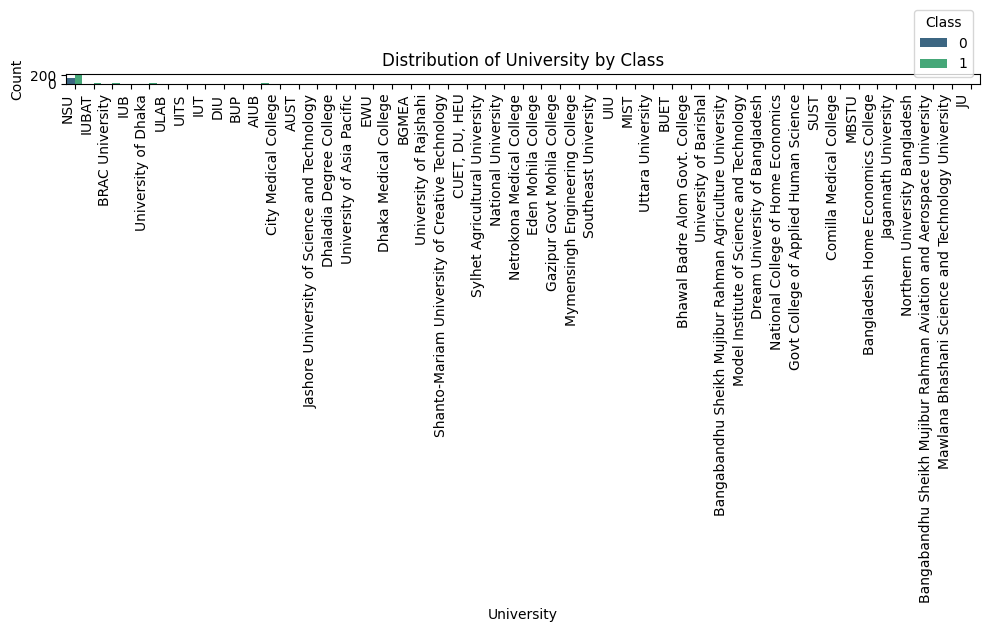

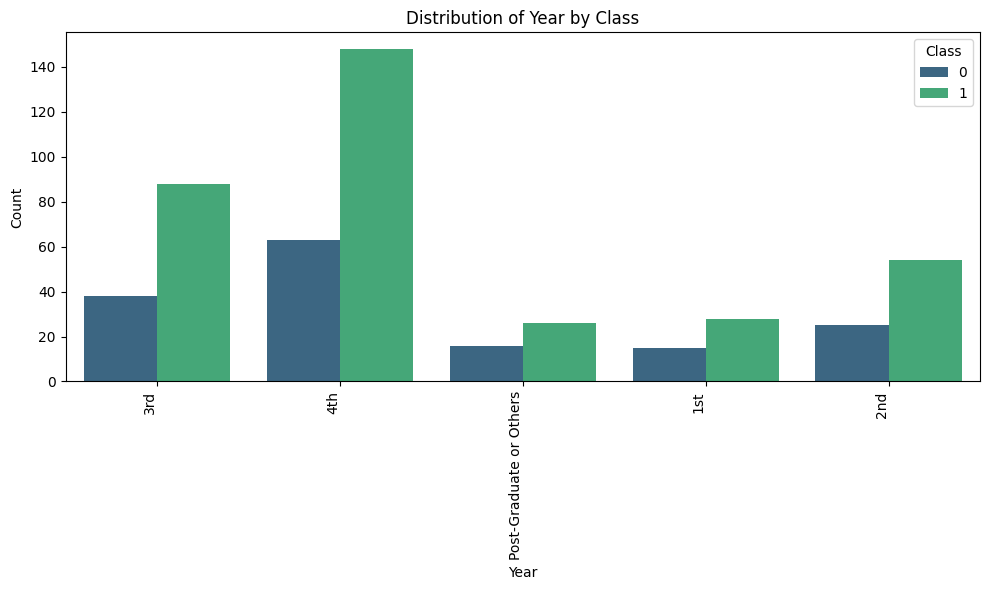

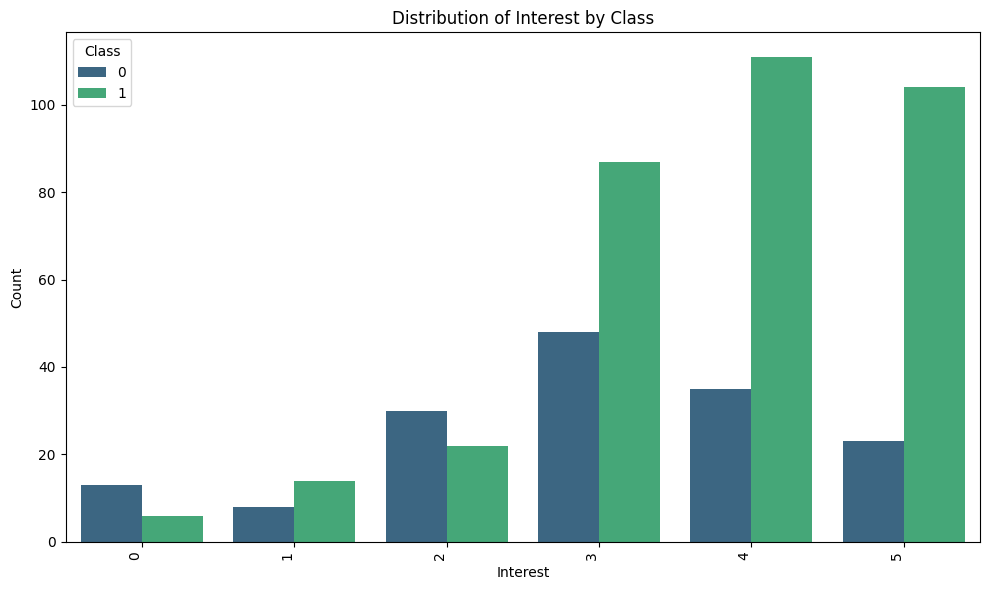

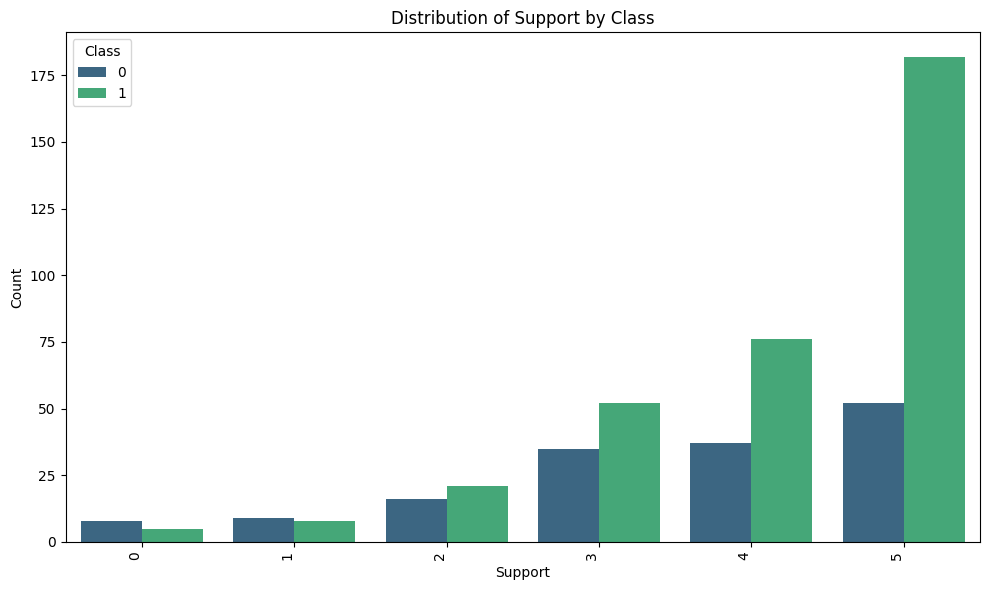

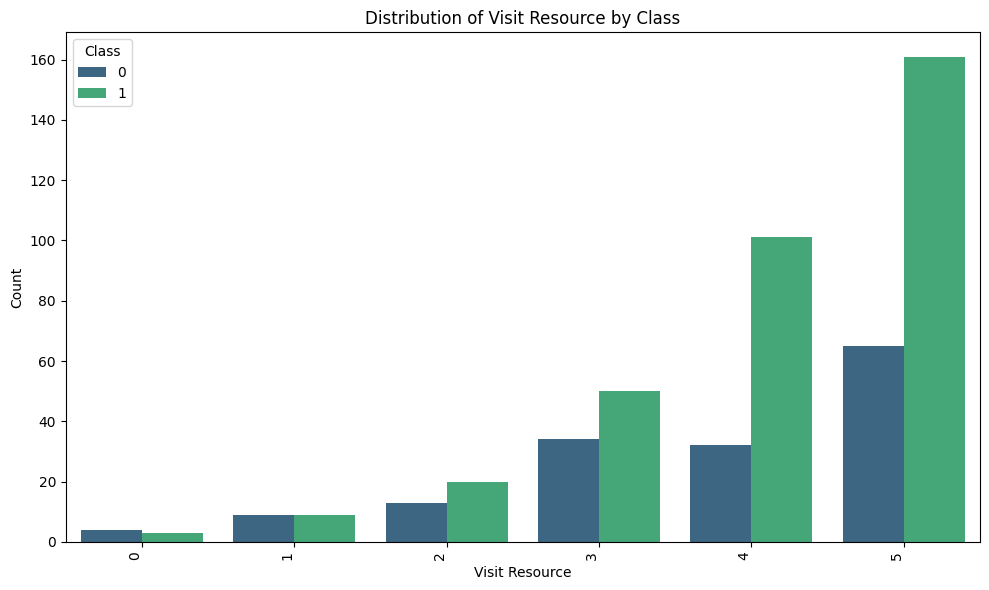

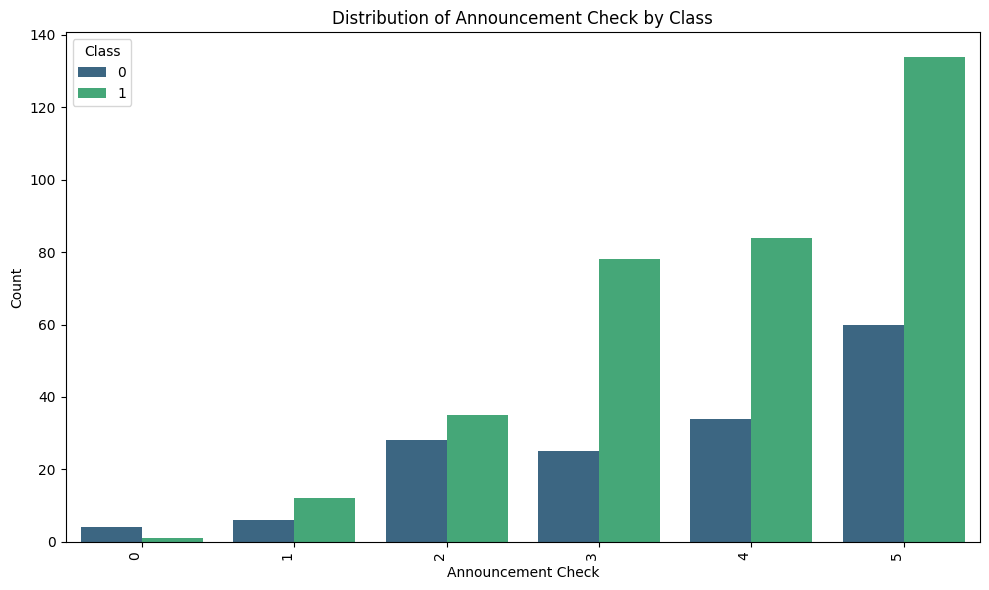

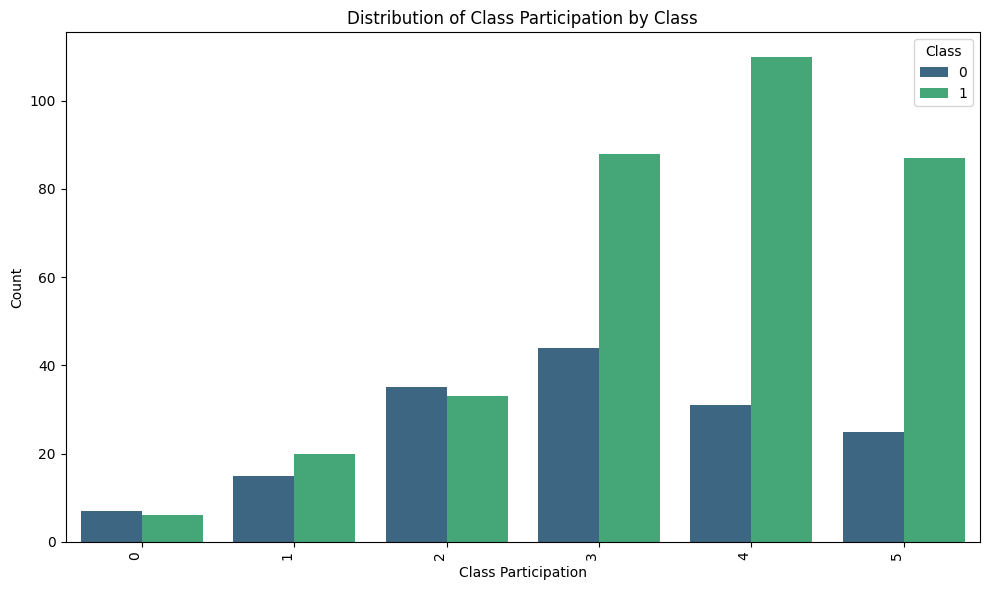

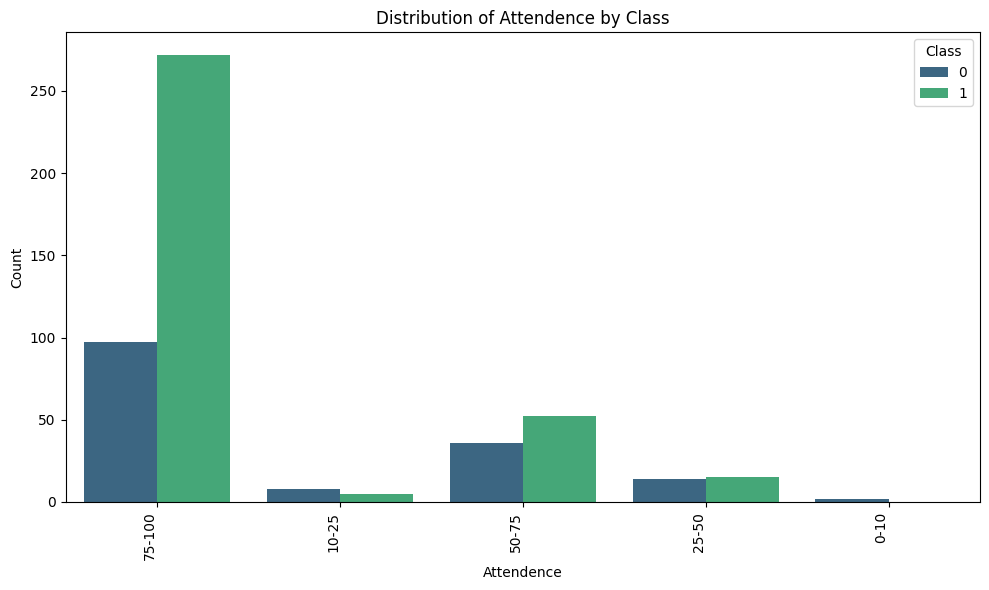

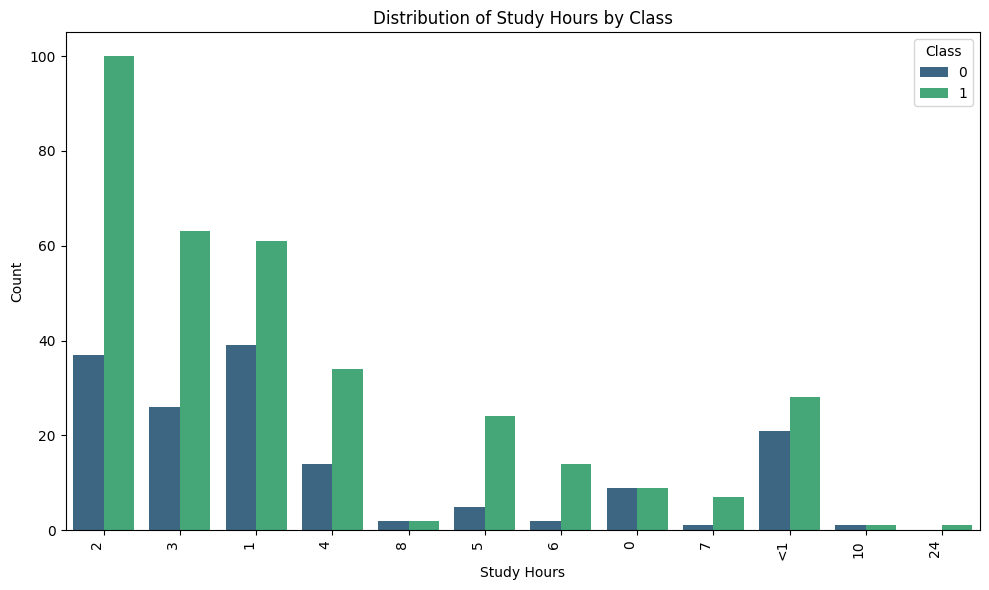

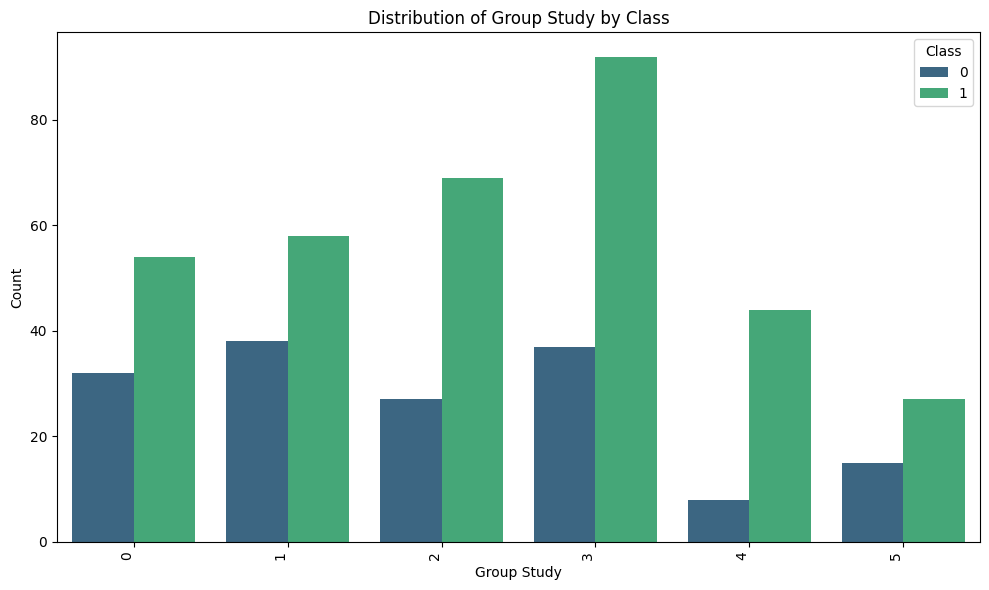

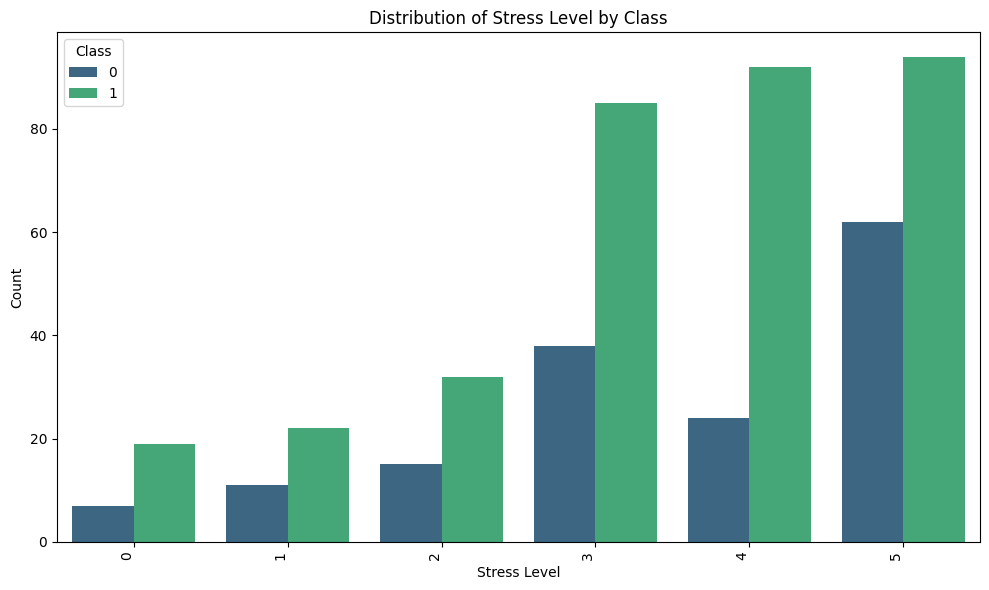

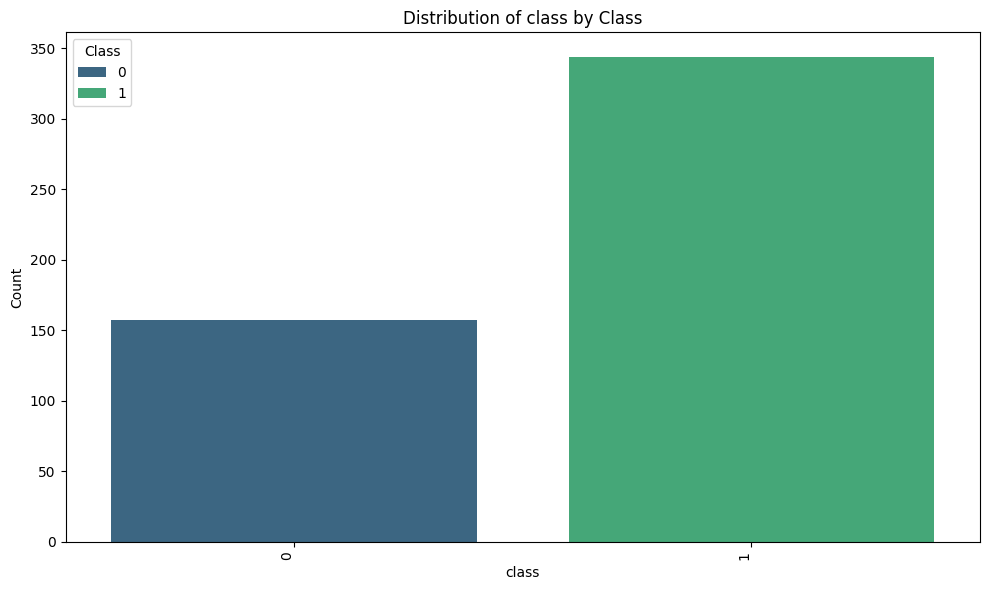

In [57]:
# Define a function to plot bar charts for each attribute with 'class' as legend
def plot_attribute_bar_chart(data, attribute_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=attribute_name, hue='class', palette='viridis')
    plt.title(f'Distribution of {attribute_name} by Class')
    plt.xlabel(attribute_name)
    plt.ylabel('Count')
    plt.legend(title='Class')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

# Loop through each attribute and plot the bar chart
for attribute in df.columns:
    plot_attribute_bar_chart(df, attribute)

In [58]:
for label in cols:
    if label == 'Attendence':
        # Convert the 'Attendence' column to numeric by taking the average of the range
        df['Attendence'] = df['Attendence'].apply(lambda x: np.mean([float(i) for i in x.split('-')]))

    fig = px.histogram(df, x=label, color="class", marginal="rug",
                       hover_data=df.columns, title=label,
                       labels={'class': 'Class'}, opacity=0.7,
                       nbins=30, template="plotly_white")

    fig.update_layout(
        xaxis_title=label,
        yaxis_title='Frequency',
        showlegend=True
    )

    fig.show()

In [59]:
# Splitting the data into features (X) and target variable (y)
X = df.drop("class", axis=1)
y = df["class"]

In [60]:
# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object']).columns

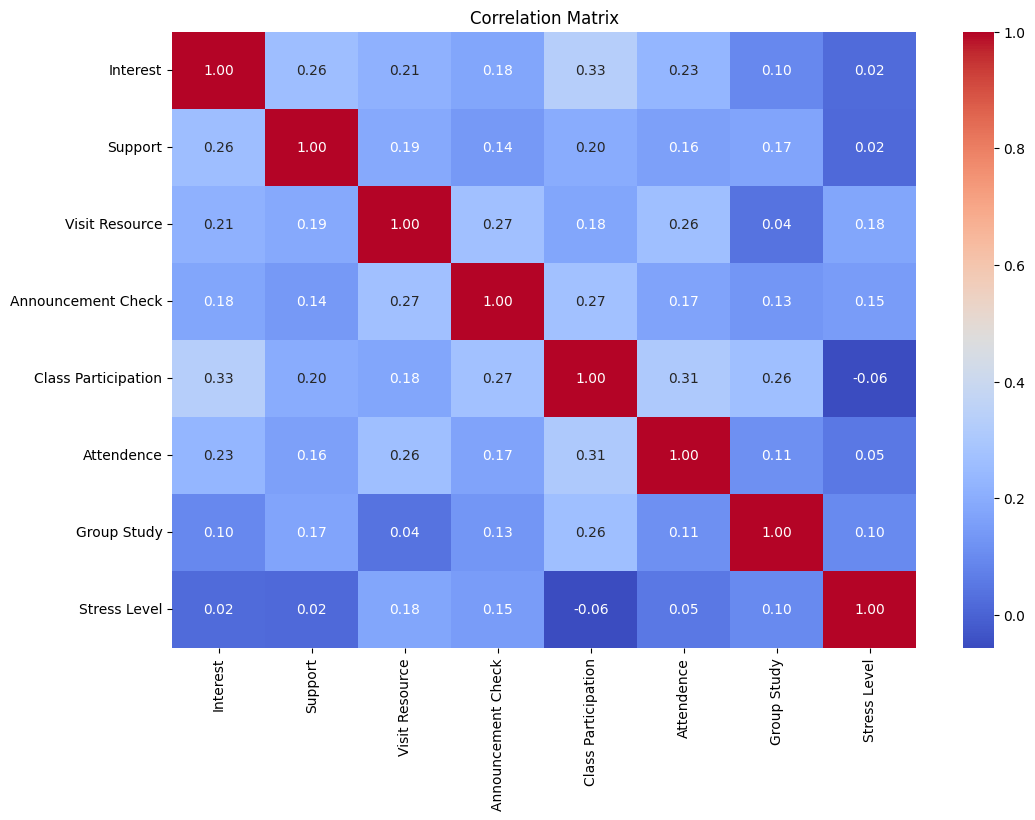

In [61]:
# Calculate the correlation matrix for numerical features only
corr_matrix = X[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [62]:
# One-hot encoding for categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[['Gender', 'University', 'Attendence']]))
X_encoded.columns = encoder.get_feature_names_out(['Gender', 'University', 'Attendence'])
X = pd.concat([X.drop(['Gender', 'University', 'Attendence'], axis=1), X_encoded], axis=1)

X.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,Year,Interest,Support,Visit Resource,Announcement Check,Class Participation,Study Hours,Group Study,Stress Level,Gender_Male,...,University_ULAB,University_University of Asia Pacific,University_University of Barishal,University_University of Dhaka,University_University of Rajshahi,University_Uttara University,Attendence_17.5,Attendence_37.5,Attendence_62.5,Attendence_87.5
0,3rd,2,5,2,4,1,2,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4th,3,4,4,5,4,2,3,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4th,5,5,4,4,4,2,5,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4th,4,4,5,5,1,2,4,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3rd,4,5,5,2,4,2,4,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
# Identify columns to exclude from scaling (e.g., categorical or one-hot encoded columns)
exclude_columns = ['Year']

# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(exclude='number').columns.tolist()

# Exclude non-numeric columns and columns in the exclude_columns list
columns_to_scale = [col for col in X.columns if col not in exclude_columns and col not in non_numeric_columns]

# Convert non-numeric values to numeric in specific columns
# For example, if 'Study' contains '<1', you can replace it with 0
X['Study Hours'] = pd.to_numeric(X['Study Hours'], errors='coerce').fillna(0)

# Scale and oversample the dataset
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

X_scaled.head()


,Year,Interest,Support,Visit Resource,Announcement Check,Class Participation,Study Hours,Group Study,Stress Level,Gender_Male,...,University_ULAB,University_University of Asia Pacific,University_University of Barishal,University_University of Dhaka,University_University of Rajshahi,University_Uttara University,Attendence_17.5,Attendence_37.5,Attendence_62.5,Attendence_87.5
0,3rd,-1.150829,0.824341,-1.663052,0.175804,-1.830618,2.0,0.542880,-0.328192,-1.226784,...,-0.100402,-0.044721,-0.044721,-0.224309,-0.089712,-0.044721,-0.163216,-0.247872,-0.461601,0.5981
1,4th,-0.380020,0.046573,0.010018,0.983858,0.481499,2.0,0.542880,-0.328192,0.815139,...,-0.100402,-0.044721,-0.044721,-0.224309,-0.089712,-0.044721,-0.163216,-0.247872,-0.461601,0.5981
2,4th,1.161599,0.824341,0.010018,0.175804,0.481499,2.0,1.869626,-2.409510,0.815139,...,-0.100402,-0.044721,-0.044721,-0.224309,-0.089712,-0.044721,-0.163216,-0.247872,-0.461601,0.5981
3,4th,0.390790,0.046573,0.846553,0.983858,-1.830618,2.0,1.206253,0.365581,-1.226784,...,-0.100402,-0.044721,-0.044721,-0.224309,-0.089712,-0.044721,-0.163216,-0.247872,-0.461601,0.5981
4,3rd,0.390790,0.824341,0.846553,-1.440304,0.481499,2.0,1.206253,-0.328192,0.815139,...,-0.100402,-0.044721,-0.044721,-0.224309,-0.089712,-0.044721,-0.163216,-0.247872,-0.461601,0.5981


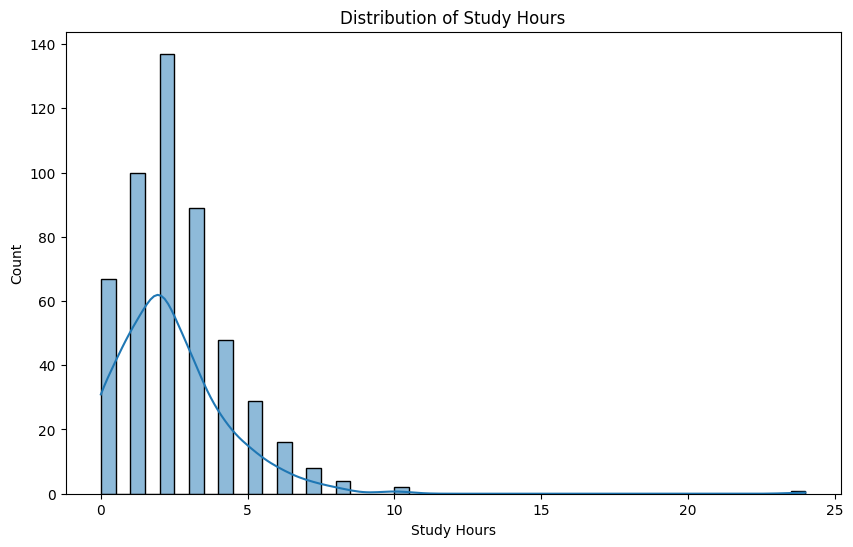

In [64]:
# Plotting the distribution of Study Hours
plt.figure(figsize=(10,6))
sns.histplot(data=X, x='Study Hours', kde=True)
plt.title('Distribution of Study Hours')
plt.show()

<ipython-input-65-b847d2a6f0ce>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




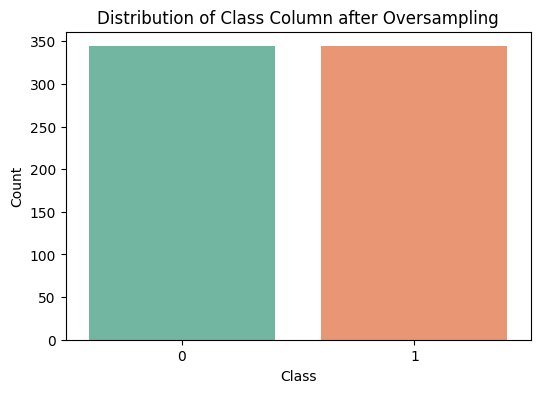

In [65]:
# Display the distribution of the 'class' column after oversampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Distribution of Class Column after Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [66]:
# Exclude non-numeric columns
numeric_columns = X_resampled.select_dtypes(include='number').columns.tolist()

# Create a new DataFrame with only numeric columns
X_numeric = X_resampled[numeric_columns]

In [67]:
# kNN
knn_model = KNeighborsClassifier(n_neighbors=5)

In [68]:
# Apply cross-validation
cv_score1 = cross_val_score(knn_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [69]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score1)
print("Mean accuracy:", np.mean(cv_score1))

Cross-validation scores: [0.68115942 0.70289855 0.76811594 0.6350365  0.72992701]
Mean accuracy: 0.7034274833386227


In [70]:
# Train-test split (optional)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [71]:
print(f"Train:{len(X_train)}")

Train:550


In [72]:
print(f"Test:{len(X_test)}")

Test:138


In [73]:
# Print the column names in X_train
print("Columns in X_train:", X_train.columns)

# Check if 'University' is in the columns
if 'University' in X_train.columns:
    # One-hot encode the 'University' column
    X_train_encoded = pd.get_dummies(X_train, columns=['University'], drop_first=True)
else:
    print("The 'University' column is not present in X_train. Check the column names.")

X.head()

Columns in X_train: Index(['Year', 'Interest', 'Support', 'Visit Resource', 'Announcement Check',
       'Class Participation', 'Study Hours', 'Group Study', 'Stress Level',
       'Gender_Male', 'University_AUST', 'University_BGMEA',
       'University_BRAC University', 'University_BUET', 'University_BUP',
       'University_Bangabandhu Sheikh Mujibur Rahman Agriculture University',
       'University_Bangabandhu Sheikh Mujibur Rahman Aviation and Aerospace University',
       'University_Bangladesh Home Economics College',
       'University_Bhawal Badre Alom Govt. College',
       'University_CUET, DU, HEU', 'University_City Medical College',
       'University_Comilla Medical College', 'University_DIU',
       'University_Dhaka Medical College',
       'University_Dhaladia Degree College',
       'University_Dream University of Bangladesh', 'University_EWU',
       'University_Eden Mohila College',
       'University_Gazipur Govt Mohila College',
       'University_Govt College of 

,Year,Interest,Support,Visit Resource,Announcement Check,Class Participation,Study Hours,Group Study,Stress Level,Gender_Male,...,University_ULAB,University_University of Asia Pacific,University_University of Barishal,University_University of Dhaka,University_University of Rajshahi,University_Uttara University,Attendence_17.5,Attendence_37.5,Attendence_62.5,Attendence_87.5
0,3rd,2,5,2,4,1,2.0,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4th,3,4,4,5,4,2.0,3,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4th,5,5,4,4,4,2.0,5,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4th,4,4,5,5,1,2.0,4,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3rd,4,5,5,2,4,2.0,4,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
# Identify non-numeric columns in X_train
non_numeric_columns_train = X_train.select_dtypes(exclude='number').columns.tolist()

# Check if there are any non-numeric columns
if non_numeric_columns_train:
    # Convert non-numeric values to numeric in specific columns
    for col in non_numeric_columns_train:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)

# Check if 'University' column is present in X_train
if 'University' in X_train.columns:
    # Check if 'University' column has string values
    if X_train['University'].dtype == 'O':
        # One-hot encode the 'University' column
        column_transformer = ColumnTransformer(
            transformers=[('encoder', OneHotEncoder(), ['University'])],
            remainder='passthrough'
        )
        X_train_encoded = pd.DataFrame(column_transformer.fit_transform(X_train[['University']]))
        X_train_encoded.columns = column_transformer.get_feature_names_out(['University'])
        X_train_encoded.index = X_train.index
        X_train = pd.concat([X_train.drop(['University'], axis=1), X_train_encoded], axis=1)

    # Fit the model on the training set
    knn_model.fit(X_train, y_train)
else:
    # If 'University' column is not present, fit the model directly on X_train
    knn_model.fit(X_train, y_train)


In [75]:
# Save the kNN model weights
joblib.dump(knn_model, 'knn_model_weights.joblib')

['knn_model_weights.joblib']

In [76]:
# Load the kNN model weights (for demonstration purposes)
loaded_knn_model = joblib.load('knn_model_weights.joblib')

In [77]:
print(loaded_knn_model)

KNeighborsClassifier()


In [78]:
# Identify non-numeric columns in X_test
non_numeric_columns_test = X_test.select_dtypes(exclude='number').columns.tolist()

# Check if there are any non-numeric columns in X_test
if non_numeric_columns_test:
    # Convert non-numeric values to numeric in specific columns
    for col in non_numeric_columns_test:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

# Make predictions on the train & test set
y_pred1 = knn_model.predict(X_train)
y_pred2 = knn_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred1))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred2))



Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       286
           1       0.87      0.76      0.81       264

    accuracy                           0.83       550
   macro avg       0.83      0.82      0.83       550
weighted avg       0.83      0.83      0.83       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        58
           1       0.81      0.59      0.68        80

    accuracy                           0.68       138
   macro avg       0.70      0.70      0.68       138
weighted avg       0.72      0.68      0.68       138



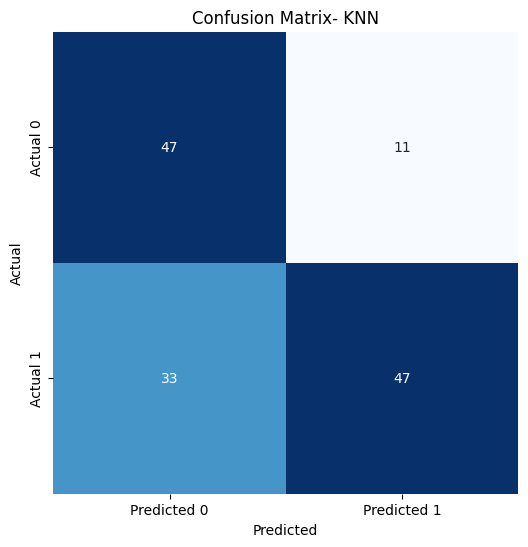

In [79]:
# Plotting the confusion matrix for KNN
cm = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- KNN')
plt.show()

In [80]:
decision_model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [81]:
# Apply cross-validation
cv_score2 = cross_val_score(decision_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [82]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score2)
print("Mean accuracy:", np.mean(cv_score2))

Cross-validation scores: [0.60869565 0.60869565 0.71014493 0.58394161 0.7080292 ]
Mean accuracy: 0.6439014069607532


In [83]:
# Train the model
decision_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [84]:
# Make predictions on the train & test set
y_pred3 = decision_model.predict(X_train)
y_pred4 = decision_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred3))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred4))


Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       286
           1       0.71      0.71      0.71       264

    accuracy                           0.72       550
   macro avg       0.72      0.72      0.72       550
weighted avg       0.72      0.72      0.72       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62        58
           1       0.73      0.70      0.71        80

    accuracy                           0.67       138
   macro avg       0.67      0.67      0.67       138
weighted avg       0.68      0.67      0.67       138



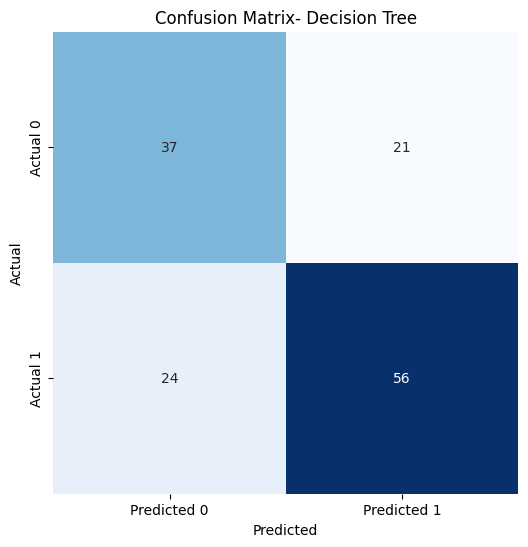

In [85]:
# Plotting the confusion matrix for Decision Tree
cm = confusion_matrix(y_test, y_pred4)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Decision Tree')
plt.show()

In [86]:
# Save the decision tree model weights
joblib.dump(decision_model, 'decision_model_weights.joblib')

['decision_model_weights.joblib']

In [87]:
# Load the kNN model weights (for demonstration purposes)
loaded_decision_model = joblib.load('decision_model_weights.joblib')

In [88]:
# Create an SVM model
SVM_model = SVC(kernel='rbf', C=1.0, random_state=42)

In [89]:
# Apply cross-validation
cv_score3 = cross_val_score(SVM_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [90]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score3)
print("Mean accuracy:", np.mean(cv_score3))

Cross-validation scores: [0.69565217 0.69565217 0.82608696 0.73722628 0.7810219 ]
Mean accuracy: 0.7471278959060615


In [91]:
SVM_model.fit(X_train, y_train)

SVC(random_state=42)

In [92]:
joblib.dump(SVM_model, 'SVM_model_weights.joblib')

['SVM_model_weights.joblib']

In [93]:
loaded_SVM_model = joblib.load('SVM_model_weights.joblib')

In [94]:
# Make predictions on the train & test set
y_pred5 = SVM_model.predict(X_train)
y_pred6 = SVM_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred5))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred6))


Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       286
           1       0.80      0.78      0.79       264

    accuracy                           0.80       550
   macro avg       0.80      0.80      0.80       550
weighted avg       0.80      0.80      0.80       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        58
           1       0.75      0.70      0.72        80

    accuracy                           0.69       138
   macro avg       0.68      0.69      0.68       138
weighted avg       0.69      0.69      0.69       138



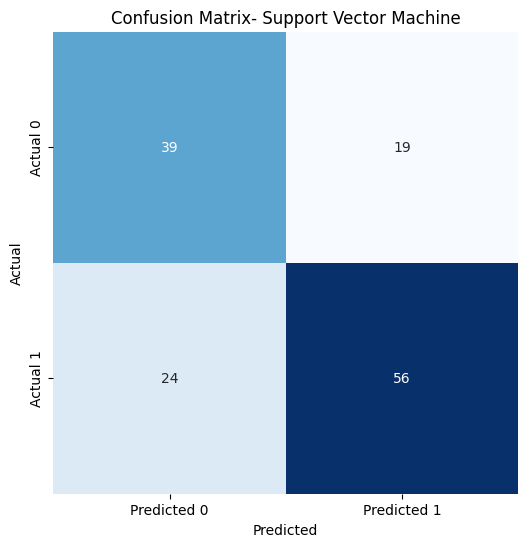

In [95]:
# Plotting the confusion matrix for SVM
cm = confusion_matrix(y_test, y_pred6)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Support Vector Machine')
plt.show()

In [96]:
# Initialize Gaussian Naive Bayes classifier
nb_model = GaussianNB()


In [97]:
# Apply cross-validation
cv_score4 = cross_val_score(nb_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [98]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score4)
print("Mean accuracy:", np.mean(cv_score4))

Cross-validation scores: [0.60144928 0.53623188 0.54347826 0.52554745 0.51824818]
Mean accuracy: 0.5449910081455622


In [99]:
nb_model.fit(X_train, y_train)

GaussianNB()

In [100]:
# Save the decision tree model weights
joblib.dump(nb_model, 'nb_model_weights.joblib')

['nb_model_weights.joblib']

In [101]:
# Load the kNN model weights (for demonstration purposes)
loaded_nb_model = joblib.load('nb_model_weights.joblib')

In [102]:
# Make predictions on the train & test set
y_pred7 = nb_model.predict(X_train)
y_pred8 = nb_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred7))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred8))


Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       286
           1       1.00      0.16      0.28       264

    accuracy                           0.60       550
   macro avg       0.78      0.58      0.50       550
weighted avg       0.77      0.60      0.51       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.44      0.98      0.61        58
           1       0.89      0.10      0.18        80

    accuracy                           0.47       138
   macro avg       0.67      0.54      0.39       138
weighted avg       0.70      0.47      0.36       138



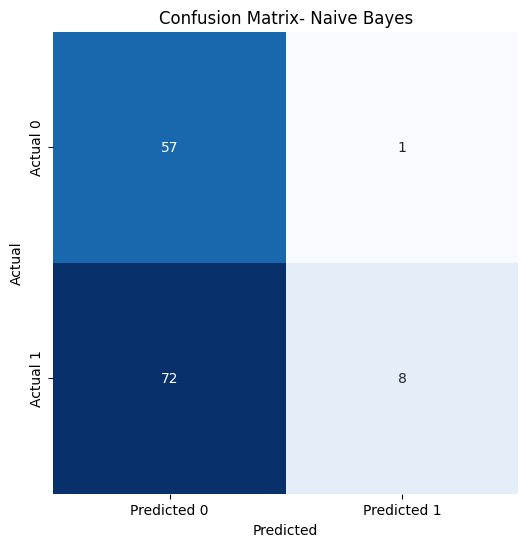

In [103]:
# Plotting the confusion matrix for Naive-Bayes
cm = confusion_matrix(y_test, y_pred8)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Naive Bayes')
plt.show()

In [104]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100,  max_depth=5, random_state=42)

In [105]:
# Apply cross-validation
cv_score5 = cross_val_score(rf_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [106]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score5)
print("Mean accuracy:", np.mean(cv_score5))

Cross-validation scores: [0.69565217 0.73188406 0.79710145 0.70072993 0.74452555]
Mean accuracy: 0.733978631122395


In [107]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [108]:
# Save the random forest model weights
joblib.dump(rf_model, 'rf_model_weights.joblib')

['rf_model_weights.joblib']

In [109]:
# Load the kNN model weights (for demonstration purposes)
loaded_rf_model = joblib.load('rf_model_weights.joblib')

In [110]:
# Make predictions on the train & test set
y_pred9 = rf_model.predict(X_train)
y_pred10 = rf_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred9))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred10))


Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       286
           1       0.81      0.81      0.81       264

    accuracy                           0.82       550
   macro avg       0.82      0.82      0.82       550
weighted avg       0.82      0.82      0.82       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        58
           1       0.76      0.78      0.77        80

    accuracy                           0.72       138
   macro avg       0.72      0.72      0.72       138
weighted avg       0.72      0.72      0.72       138



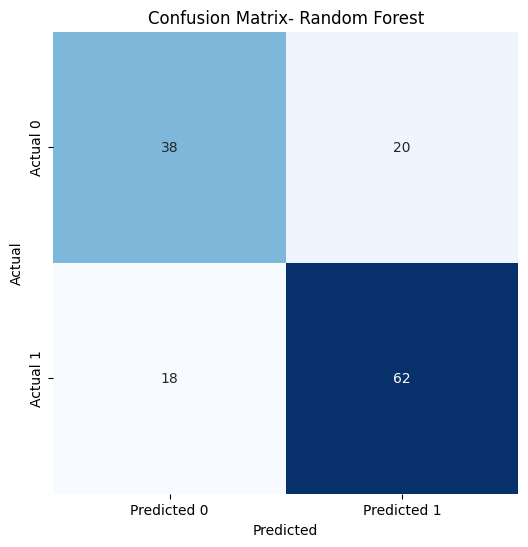

In [111]:
# Plotting the confusion matrix for random forest
cm = confusion_matrix(y_test, y_pred10)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Random Forest')
plt.show()

In [112]:
# Initialize Logistic Regression model
regression_model = LogisticRegression(C=10.0, random_state=42)


In [113]:
# Apply cross-validation
cv_score6 = cross_val_score(regression_model, X_numeric, y_resampled, cv=5, scoring='accuracy')

In [114]:
# Display cross-validation scores
print("Cross-validation scores:", cv_score6)
print("Mean accuracy:", np.mean(cv_score6))

Cross-validation scores: [0.71014493 0.70289855 0.79710145 0.71532847 0.74452555]
Mean accuracy: 0.7339997884269545


In [115]:
regression_model.fit(X_train, y_train)

LogisticRegression(C=10.0, random_state=42)

In [116]:
# Save the decision tree model weights
joblib.dump(regression_model, 'regression_model_weights.joblib')

['regression_model_weights.joblib']

In [117]:
# Load the kNN model weights (for demonstration purposes)
loaded_regression_model = joblib.load('regression_model_weights.joblib')

In [118]:
# Make predictions on the train & test set
y_pred11 = regression_model.predict(X_train)
y_pred12 = regression_model.predict(X_test)

# Evaluate the model on the train set
print("\nTrain Set Evaluation:")
print(classification_report(y_train, y_pred11))
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred12))


Train Set Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       286
           1       0.79      0.74      0.76       264

    accuracy                           0.78       550
   macro avg       0.78      0.78      0.78       550
weighted avg       0.78      0.78      0.78       550


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.59      0.71      0.65        58
           1       0.75      0.65      0.70        80

    accuracy                           0.67       138
   macro avg       0.67      0.68      0.67       138
weighted avg       0.69      0.67      0.68       138



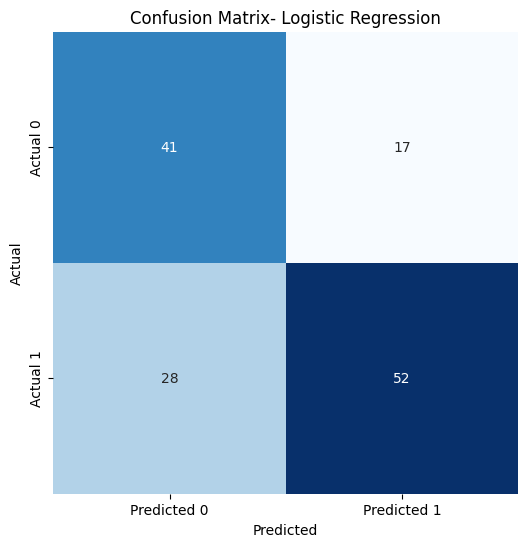

In [119]:
# Plotting the confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred12)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Logistic Regression')
plt.show()

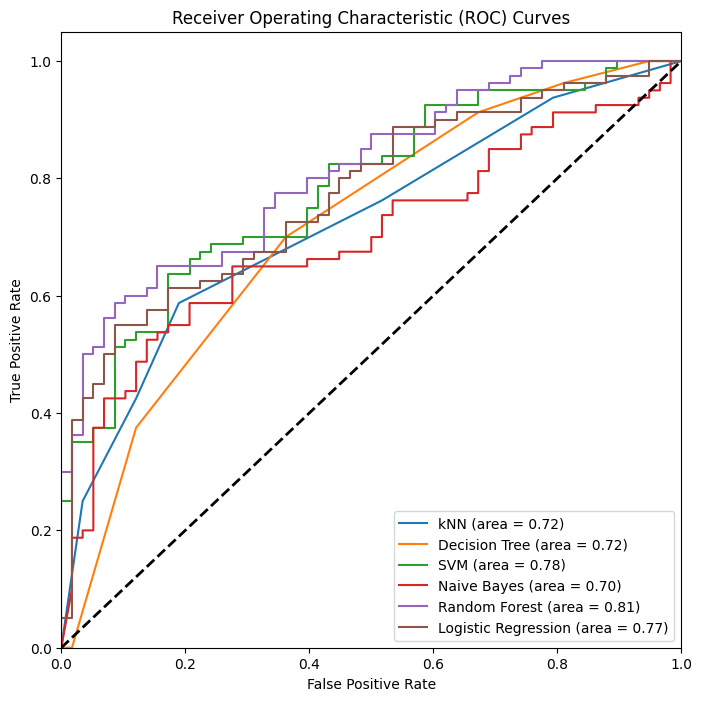

In [120]:
# Function to plot ROC curve for binary classification
def plot_roc_curve_binary(model, X, y, model_name):
    y_bin = label_binarize(y, classes=[0, 1])

    # Binarize the output
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        raise ValueError("Model does not have predict_proba or decision_function")

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_bin, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:0.2f})')

# List of binary classification models
binary_models = [knn_model, decision_model, SVM_model, nb_model, rf_model, regression_model]
binary_model_names = ['kNN', 'Decision Tree', 'SVM', 'Naive Bayes', 'Random Forest', 'Logistic Regression']

# Plot ROC curves for binary classification models
plt.figure(figsize=(8, 8))

for model, name in zip(binary_models, binary_model_names):
    plot_roc_curve_binary(model, X_test, y_test, name)

# Plot a diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

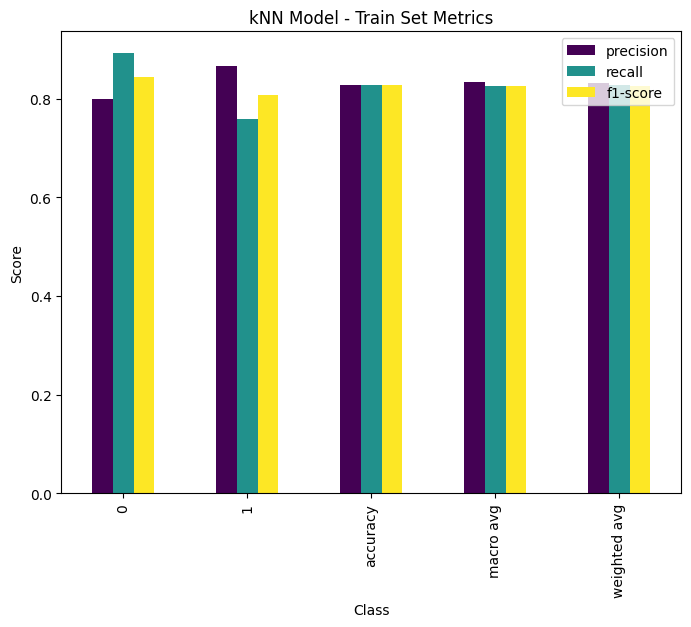

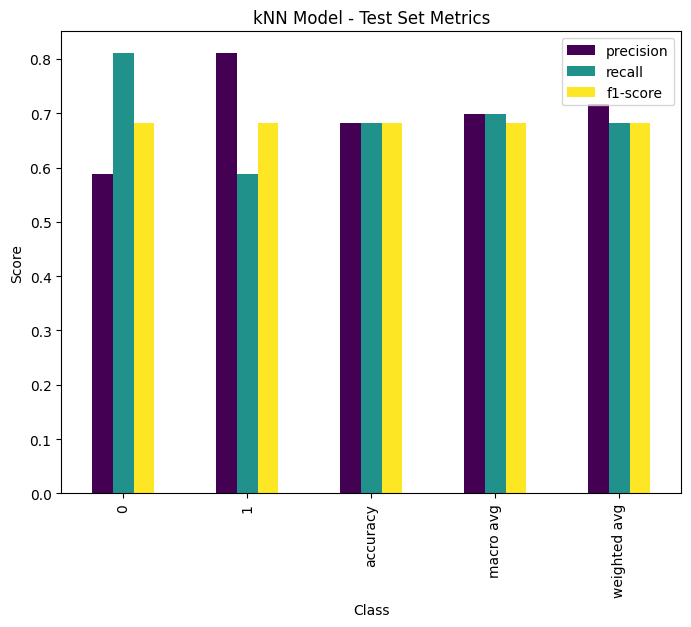

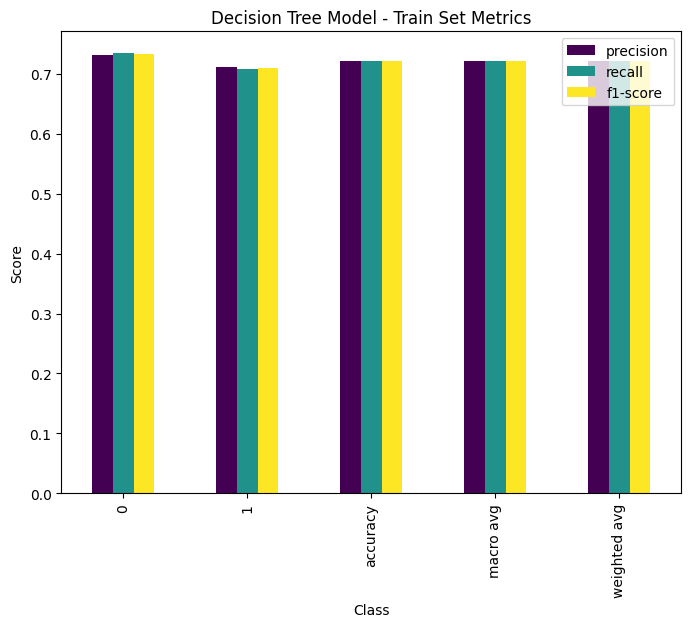

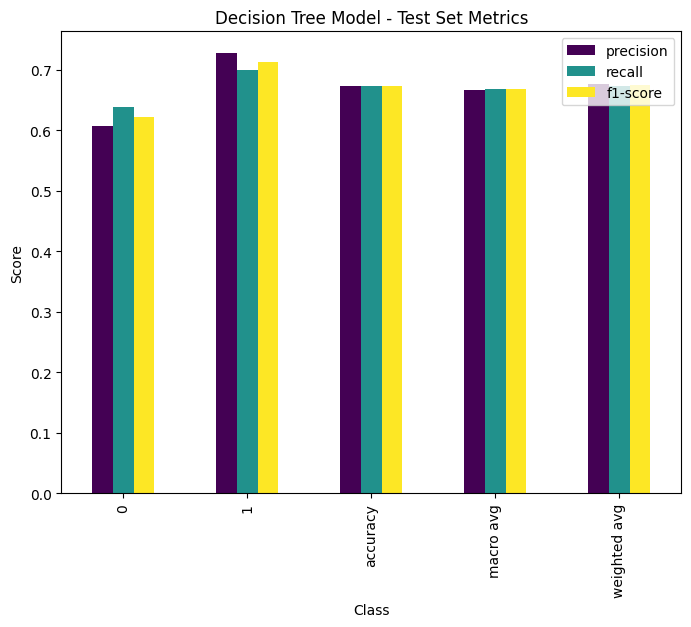

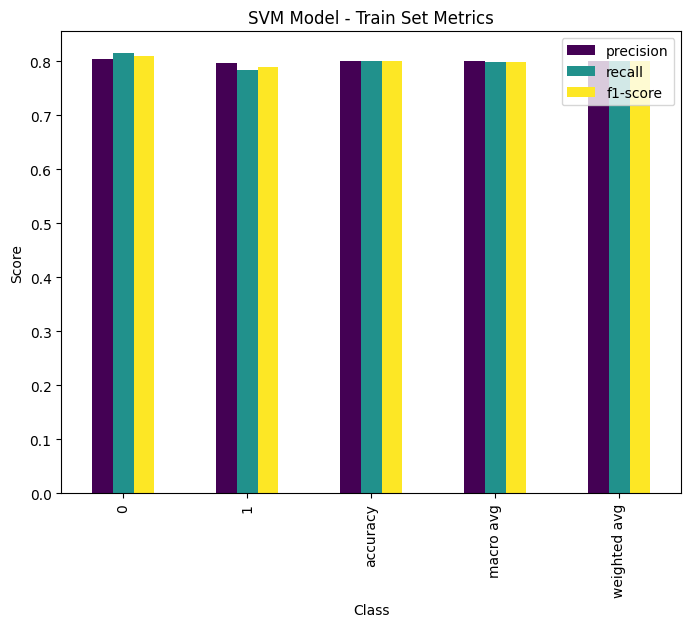

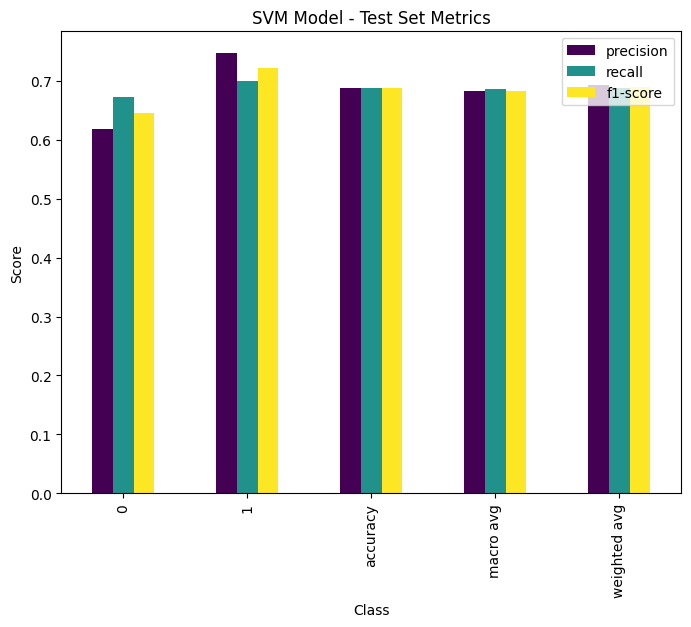

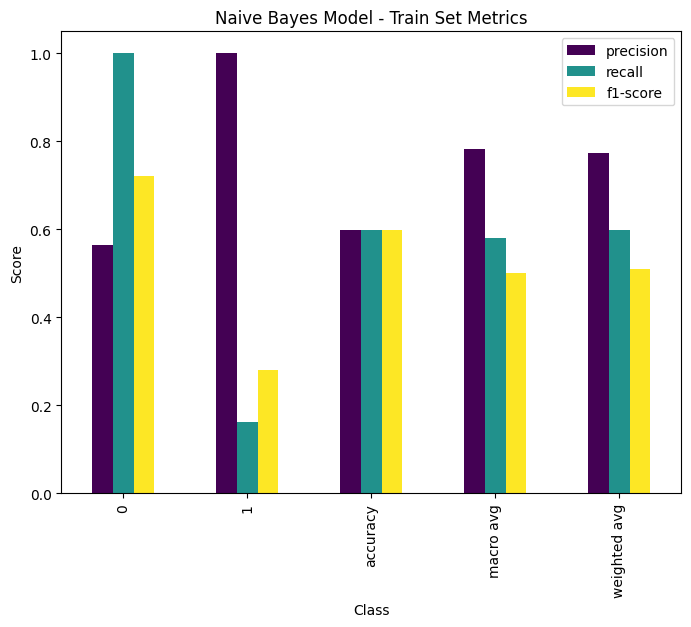

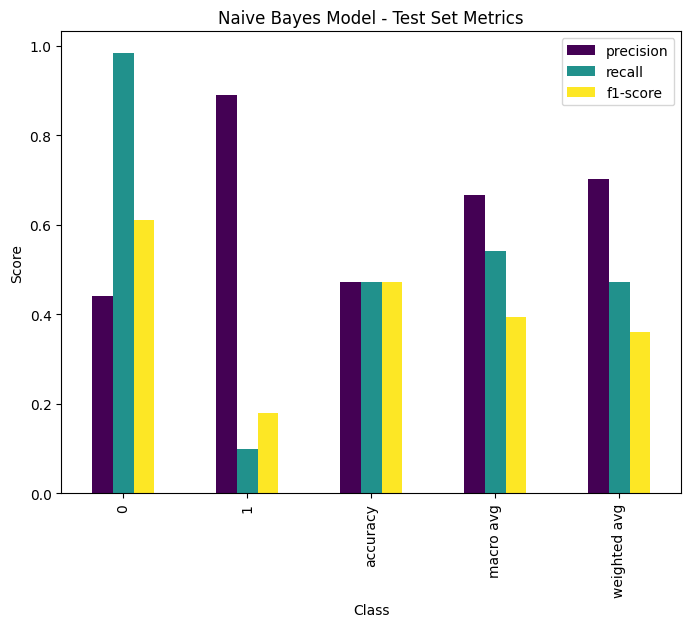

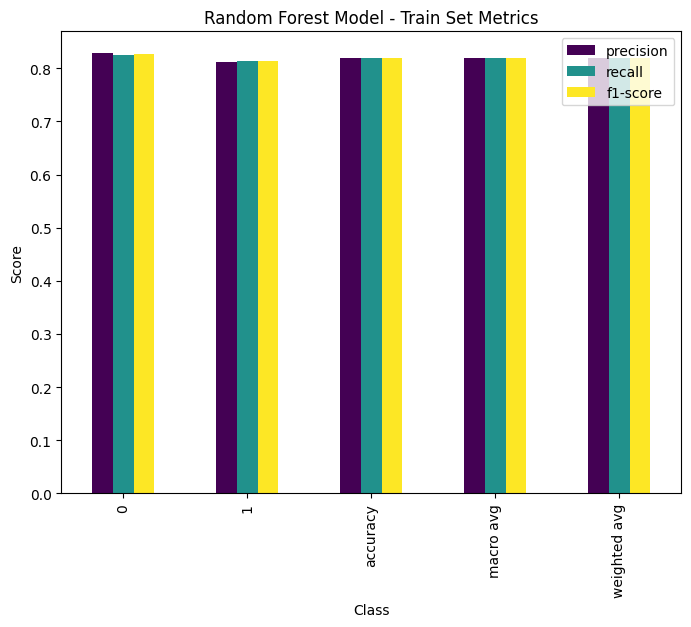

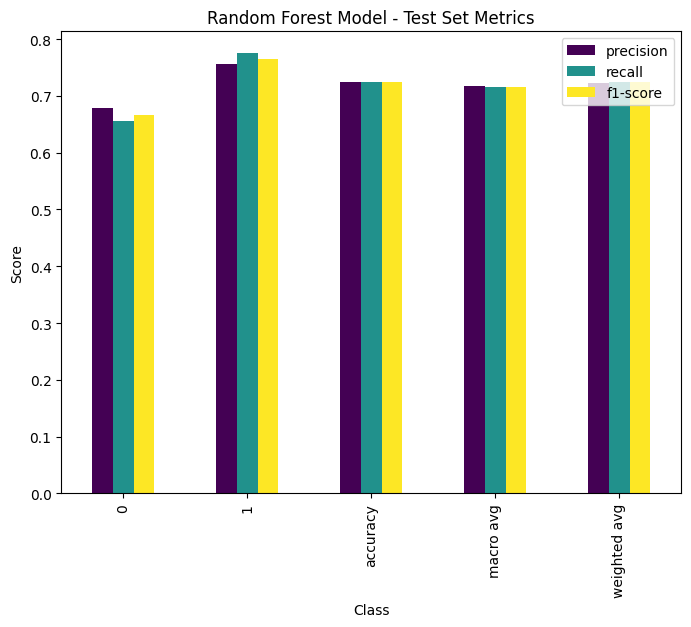

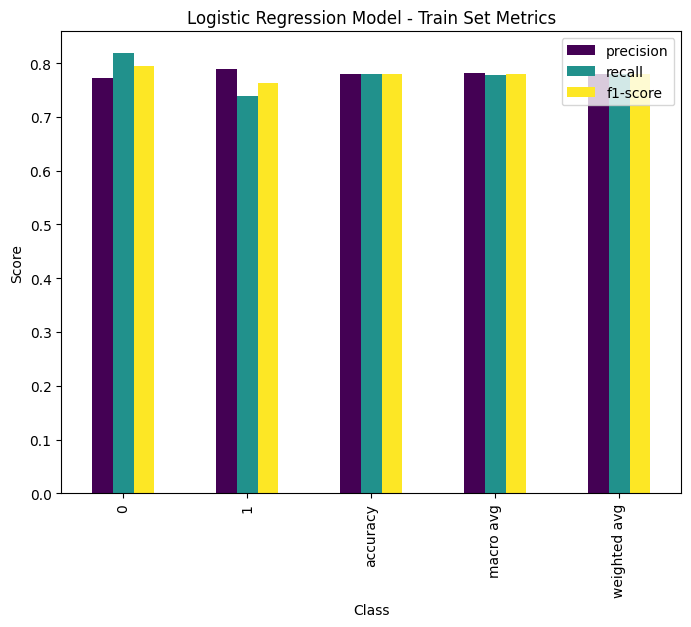

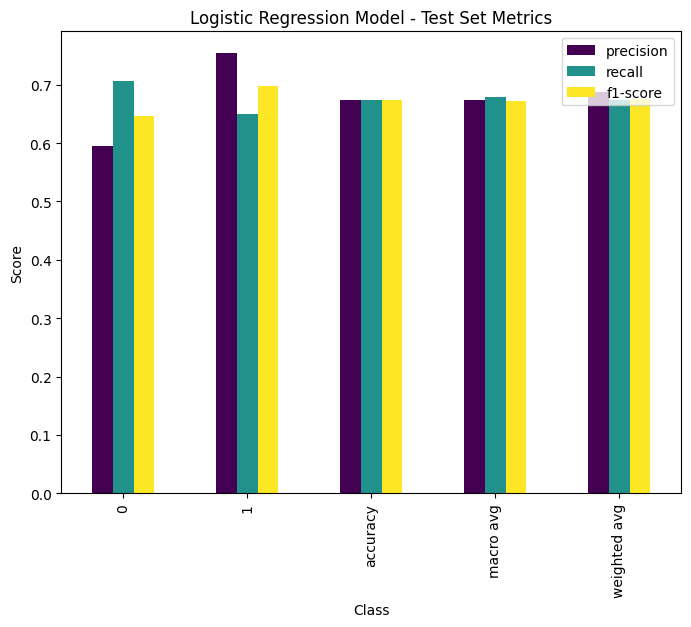

In [121]:
# Function to plot bar plot for recall, precision, and f1 score
def plot_evaluation_metrics(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()

    # Extract relevant metrics
    metrics_subset = metrics_df[['precision', 'recall', 'f1-score']]

    # Plot bar plot
    metrics_subset.plot(kind='bar', colormap='viridis', figsize=(8, 6))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(loc='upper right')
    plt.show()

# Evaluate and plot metrics for kNN model with oversampling
plot_evaluation_metrics(y_train, y_pred1, 'kNN Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred2, 'kNN Model - Test Set Metrics')

# Evaluate and plot metrics for Decision Tree model with oversampling
plot_evaluation_metrics(y_train, y_pred3, 'Decision Tree Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred4, 'Decision Tree Model - Test Set Metrics')

# Evaluate and plot metrics for SVM model with oversampling
plot_evaluation_metrics(y_train, y_pred5, 'SVM Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred6, 'SVM Model - Test Set Metrics')

# Evaluate and plot metrics for Naive Bayes model with oversampling
plot_evaluation_metrics(y_train, y_pred7, 'Naive Bayes Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred8, 'Naive Bayes Model - Test Set Metrics')

# Evaluate and plot metrics for Random Forest model with oversampling
plot_evaluation_metrics(y_train, y_pred9, 'Random Forest Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred10, 'Random Forest Model - Test Set Metrics')

# Evaluate and plot metrics for Logistic Regression model with oversampling
plot_evaluation_metrics(y_train, y_pred11, 'Logistic Regression Model - Train Set Metrics')
plot_evaluation_metrics(y_test, y_pred12, 'Logistic Regression Model - Test Set Metrics')



In [122]:
# Create a list of models for iteration
models = [knn_model, decision_model, SVM_model, nb_model, rf_model, regression_model]


In [123]:
# Create dictionaries to store results
train_results = {'model': [], 'precision': [], 'recall': [], 'f1_score': [], 'accuracy': []}
test_results = {'model': [], 'precision': [], 'recall': [], 'f1_score': [], 'accuracy': []}

In [124]:
# Loop through models
for model, model_name in zip(models, binary_model_names):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the train & test set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate the model on the train set
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    train_results['model'].append(model_name)
    train_results['precision'].append(train_report['weighted avg']['precision'])
    train_results['recall'].append(train_report['weighted avg']['recall'])
    train_results['f1_score'].append(train_report['weighted avg']['f1-score'])
    train_results['accuracy'].append(train_report['accuracy'])

    # Evaluate the model on the test set
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    test_results['model'].append(model_name)
    test_results['precision'].append(test_report['weighted avg']['precision'])
    test_results['recall'].append(test_report['weighted avg']['recall'])
    test_results['f1_score'].append(test_report['weighted avg']['f1-score'])
    test_results['accuracy'].append(test_report['accuracy'])


In [125]:
# Create DataFrames from the results
train_results_df = pd.DataFrame(train_results)
test_results_df = pd.DataFrame(test_results)

In [126]:
# Display the results
print("Train Results:")
print(train_results_df)

print("\nTest Results:")
print(test_results_df)

Train Results:
                 model  precision    recall  f1_score  accuracy
0                  kNN   0.831258  0.827273  0.826226  0.827273
1        Decision Tree   0.721781  0.721818  0.721797  0.721818
2                  SVM   0.799947  0.800000  0.799931  0.800000
3          Naive Bayes   0.773333  0.598182  0.509545  0.598182
4        Random Forest   0.820030  0.820000  0.820013  0.820000
5  Logistic Regression   0.780532  0.780000  0.779515  0.780000

Test Results:
                 model  precision    recall  f1_score  accuracy
0                  kNN   0.716685  0.681159  0.681159  0.681159
1        Decision Tree   0.676537  0.673913  0.674908  0.673913
2                  SVM   0.693030  0.688406  0.689818  0.688406
3          Naive Bayes   0.701007  0.471014  0.360437  0.471014
4        Random Forest   0.723514  0.724638  0.723922  0.724638
5  Logistic Regression   0.686620  0.673913  0.675998  0.673913


In [127]:
# Generate a table comparing overall precision, recall, F1-score, and accuracy
overall_results_df = pd.DataFrame({
    'Model': binary_model_names,
    'Overall Precision': test_results_df.groupby('model')['precision'].mean().loc[binary_model_names].values,
    'Overall Recall': test_results_df.groupby('model')['recall'].mean().loc[binary_model_names].values,
    'Overall F1-Score': test_results_df.groupby('model')['f1_score'].mean().loc[binary_model_names].values,
    'Overall Accuracy': test_results_df.groupby('model')['accuracy'].mean().loc[binary_model_names].values
})

In [128]:
# Format the table using tabulate
formatted_table = tabulate(overall_results_df, headers='keys', tablefmt='pretty', showindex=False)

In [129]:
print("\nOverall Results:")
print(overall_results_df)


Overall Results:
                 Model  Overall Precision  Overall Recall  Overall F1-Score  \
0                  kNN           0.716685        0.681159          0.681159   
1        Decision Tree           0.676537        0.673913          0.674908   
2                  SVM           0.693030        0.688406          0.689818   
3          Naive Bayes           0.701007        0.471014          0.360437   
4        Random Forest           0.723514        0.724638          0.723922   
5  Logistic Regression           0.686620        0.673913          0.675998   

   Overall Accuracy  
0          0.681159  
1          0.673913  
2          0.688406  
3          0.471014  
4          0.724638  
5          0.673913  


<ipython-input-130-68ba8d607c96>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-130-68ba8d607c96>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-130-68ba8d607c96>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-130-68ba8d607c96>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




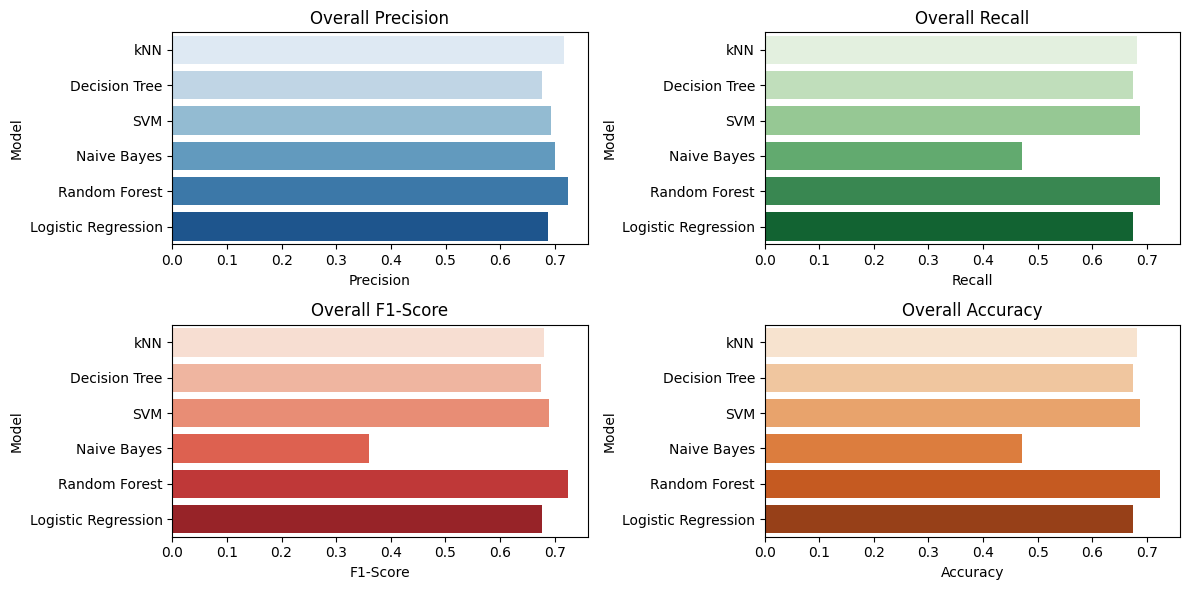

In [130]:
# Visualize overall results in a single graph
plt.figure(figsize=(12, 6))

# Bar plot for precision
plt.subplot(2, 2, 1)
sns.barplot(x='Overall Precision', y='Model', data=overall_results_df, palette='Blues')
plt.title('Overall Precision')
plt.xlabel('Precision')

# Bar plot for recall
plt.subplot(2, 2, 2)
sns.barplot(x='Overall Recall', y='Model', data=overall_results_df, palette='Greens')
plt.title('Overall Recall')
plt.xlabel('Recall')

# Bar plot for F1-score
plt.subplot(2, 2, 3)
sns.barplot(x='Overall F1-Score', y='Model', data=overall_results_df, palette='Reds')
plt.title('Overall F1-Score')
plt.xlabel('F1-Score')

# Bar plot for accuracy
plt.subplot(2, 2, 4)
sns.barplot(x='Overall Accuracy', y='Model', data=overall_results_df, palette='Oranges')
plt.title('Overall Accuracy')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()